In [15]:
import pandas as pd
from matplotlib import pyplot as plt
import glob
import matplotlib.dates as mdates
import numpy as np
from datetime import timedelta
from tqdm import tqdm
import datetime as dt
from datetime import time
import math
from datetime import datetime

In [16]:
def reader(path, first_var):
    '''
    Reads SEMS/DASH data, adds datetime columns

    :param path: path to data file
    :param first_var: the name of the fir column label
    :return: pandas DataFrame
    '''
    # Open the file and read the lines
    skip=1
    with open(path, "r") as file:
        # Iterate over the lines
        for line in file:
            # rip leading and trailing whitespace
            line = line.strip()
            # Check if the line contains column names
            if line.startswith(first_var):
                # Split the line by whitespace and append to the columns list
                columns = line[1:].strip().split("\t")
                break
            skip+=1
    # Read the data into a DataFrame, skipping the first 6 rows of comments
    d = pd.read_csv(path, sep='\t', skiprows=skip, names=columns, low_memory=False)
    #Check for duplicated metadata, remove metadata rows based on string "OPC SN"
    if len(d)>0:
        if isinstance(d.iloc[0,0], str):
            dup_meta = [n for n, i in enumerate(d.iloc[:,0]) if 'OPC SN' in i]
            if len(dup_meta) > 0:
                for line in dup_meta:
                    #Deletes duplicate metadata rows from dataframe
                    d.drop(np.arange(line,line+68), inplace = True)
                    # Apply the function to each column
                    d_og = d.copy()
                    for c in d.keys():
                        try:
                            d[c] = pd.to_numeric(d_og[c])
                        except:
                            d[c] = d_og[c]
                    #d = d.apply(pd.to_numeric, ‘raise’,)
                    
    # Creates datetime columns
    if 'DOY.Frac' in d.keys():
        d['dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['DOY.Frac'], unit='D') - pd.Timedelta(days=1)
    if 'StartTimeSt' in d.keys():
        d['st_dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['StartTimeSt'], unit='D') - pd.Timedelta(days=1)
    if 'EndTimeSt' in d.keys():
        d['end_dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['EndTimeSt'], unit='D') - pd.Timedelta(days=1)
    if 'YY/MM/DD' and 'HR:MN:SC' in d.keys():
        d['dt'] = pd.to_datetime(str(20) + d['YY/MM/DD'] + ' ' + d['HR:MN:SC'], format='%Y/%m/%d %H:%M:%S')
    return d

In [17]:
def glob_reader(file_key, first_var, subfolder = './data/'):
    '''
    Reads groups of data files and merges them into one

    :param file_key: shared key in filenames
    :param first_var: the name of the first column label
    :param subfolder: name of the subfolder containing the data
    :return: pandas DataFrame
    '''
    paths = sorted(glob.glob(subfolder+'*'+file_key+'*'))
    d = []
    for i in range(0, len(paths)):
        f = reader(paths[i], first_var)
        if len(f)>0:
            d.append(f)
    d = pd.concat(d).reset_index()
    return d

In [18]:
def read_all_data():

    folders = sorted(glob.glob('./data/DASH-flight*'))

    dopc = []
    hopc = []
    dash = []
    sems = []

    for i in range(0, len(folders)):
        path = folders[i] + '/'
        dopc.append(glob_reader('OPC_212', '#YY/MM/DD', subfolder = path).drop_duplicates(subset='dt', keep='first'))
        hopc.append(glob_reader('OPC_210', '#YY/MM/DD', subfolder = path).drop_duplicates(subset='dt', keep='first'))
        dash.append(glob_reader('DASH_FLOW', '#DOY.Frac', subfolder = path).drop_duplicates(subset='dt', keep='first'))
        sems.append(glob_reader('SEMS_DATA', '#DOY.Frac', subfolder = path).drop_duplicates(subset='dt', keep='first'))
    
    dopc = pd.concat(dopc, ignore_index=True)
    hopc = pd.concat(hopc, ignore_index=True)
    dash = pd.concat(dash, ignore_index=True)
    sems = pd.concat(sems, ignore_index=True)
    
    # merge the DataFrames based on the DOPC times
    merged = pd.merge_asof(dopc, hopc, on='dt', direction = 'nearest', tolerance=timedelta(seconds=.9)).drop(columns=['index_x']).drop_duplicates(subset='dt', keep='first').reset_index()
    merged = pd.merge_asof(merged, dash, on='dt', direction = 'nearest', tolerance=timedelta(seconds=.9)).drop(columns=['index_x']).drop_duplicates(subset='dt', keep='first').reset_index()
    merged = pd.merge_asof(merged, sems, on='dt', direction = 'nearest', tolerance=timedelta(seconds=.9)).drop(columns=['index_x']).drop_duplicates(subset='dt', keep='first').reset_index()

    return merged

In [19]:
ft = pd.read_csv('./meta/ARCSIX_takeoff_landing_times.txt', parse_dates=['Takeoff_UTC', 'Landing_UTC', 'LARGE_Filter_Off_UTC', 'LARGE_Filter_On_UTC'])
ls = pd.read_csv('./meta/ARCSIX_DASH_SEMS_switch_times.txt', parse_dates=['Switch_Start_UTC', 'Switch_Stop_UTC'])
d = read_all_data()

In [20]:
ls

,FltNum,Switch_Start_UTC,Switch_Stop_UTC,LARGE_From,LARGE_To,Notes
0,1,2024-05-28 12:01:00,NaT,SEMS,OFF,"For RF1, we removed SEMS-DASH completely from ..."
1,1,NaT,2024-05-28 15:23:00,OFF,SEMS,This means that LARGE manifold was connected t...
2,2,2024-05-30 11:07:30,2024-05-30 11:08:30,SEMS,DASH,Switch from SEMS-DASH to DASH Only; Extended t...
3,2,2024-05-30 13:25:00,2024-05-30 13:26:00,DASH,SEMS,Switch from DASH Only to SEMS-DASH; Extended t...
4,2,2024-05-30 16:28:00,2024-05-30 16:29:00,SEMS,DASH,NaN
5,2,2024-05-30 17:47:00,2024-05-30 17:48:55,DASH,SEMS,NaN
6,3,2024-05-31 12:37:25,2024-05-31 12:38:40,SEMS,DASH,NaN
7,3,2024-05-31 15:20:30,2024-05-31 15:21:30,DASH,SEMS,NaN
8,3,2024-05-31 16:47:10,2024-05-31 16:48:30,SEMS,DASH,NaN
9,3,2024-05-31 18:21:00,2024-05-31 18:22:10,DASH,SEMS,NaN


In [21]:
for i in range(0, len(ls)):
    if pd.isna(ls.loc[i,'Switch_Start_UTC']):
        ls.loc[i,'Switch_Start_UTC'] = ls.loc[i,'Switch_Stop_UTC'] - timedelta(seconds=10)
    if pd.isna(ls.loc[i,'Switch_Stop_UTC']):
        ls.loc[i,'Switch_Stop_UTC'] = ls.loc[i,'Switch_Start_UTC'] + timedelta(seconds=10)

In [22]:
ls

,FltNum,Switch_Start_UTC,Switch_Stop_UTC,LARGE_From,LARGE_To,Notes
0,1,2024-05-28 12:01:00,2024-05-28 12:01:10,SEMS,OFF,"For RF1, we removed SEMS-DASH completely from ..."
1,1,2024-05-28 15:22:50,2024-05-28 15:23:00,OFF,SEMS,This means that LARGE manifold was connected t...
2,2,2024-05-30 11:07:30,2024-05-30 11:08:30,SEMS,DASH,Switch from SEMS-DASH to DASH Only; Extended t...
3,2,2024-05-30 13:25:00,2024-05-30 13:26:00,DASH,SEMS,Switch from DASH Only to SEMS-DASH; Extended t...
4,2,2024-05-30 16:28:00,2024-05-30 16:29:00,SEMS,DASH,NaN
5,2,2024-05-30 17:47:00,2024-05-30 17:48:55,DASH,SEMS,NaN
6,3,2024-05-31 12:37:25,2024-05-31 12:38:40,SEMS,DASH,NaN
7,3,2024-05-31 15:20:30,2024-05-31 15:21:30,DASH,SEMS,NaN
8,3,2024-05-31 16:47:10,2024-05-31 16:48:30,SEMS,DASH,NaN
9,3,2024-05-31 18:21:00,2024-05-31 18:22:10,DASH,SEMS,NaN


In [33]:
def retrieve_flows(d):
    
    # filter out for flight times
    d_out = pd.DataFrame()
    f_ac = 0
    for _, row in ft.iterrows():
        mask = (d['dt'] >= row['LARGE_Filter_Off_UTC']) & (d['dt'] <= row['LARGE_Filter_On_UTC'])
        filtered = d.loc[mask]
        d_out = pd.concat([d_out, filtered], ignore_index=True)
    d_out['input_flow_lpm'] = d_out['UpSt_Samp']
    d_out['P_hPa'] = d_out['UpSt_Press']
    d_out['T_C'] = d_out['UpSt_T']
    d_out['instrument'] = 'SEMS'
    
    for i, row in ls.iterrows():
        if row['LARGE_To'] == 'OFF':
            mask = (d_out['dt'] >= row['Switch_Start_UTC']) & (d_out['dt'] <= row['Switch_Stop_UTC'])
            d_out.loc[mask,'input_flow_lpm'] = np.nan
            d_out.loc[mask,'P_hPa'] = np.nan
            d_out.loc[mask,'T_C'] = np.nan
            d_out.loc[mask,'instrument'] = 'line break'

            mask = (d_out['dt'] >= row['Switch_Stop_UTC']) & (d_out['dt'] <= ls.loc[i+1,'Switch_Start_UTC'])
            d_out.loc[mask,'input_flow_lpm'] = 0.0
            d_out.loc[mask,'P_hPa'] = np.nan
            d_out.loc[mask,'T_C'] = np.nan
            d_out.loc[mask,'instrument'] = 'off'

        elif row['LARGE_To'] == 'DASH':
            mask = (d_out['dt'] >= row['Switch_Start_UTC']) & (d_out['dt'] <= row['Switch_Stop_UTC'])
            #print('DASH', len(mask[mask==True]), row['Switch_Start_UTC'], row['Switch_Stop_UTC'], np.nan)
            d_out.loc[mask,'input_flow_lpm'] = np.nan
            d_out.loc[mask,'P_hPa'] = np.nan
            d_out.loc[mask,'T_C'] = np.nan
            d_out.loc[mask,'instrument'] = 'line break'

            mask = (d_out['dt'] >= row['Switch_Start_UTC']+timedelta(seconds=10)) & (d_out['dt'] <= row['Switch_Stop_UTC']-timedelta(seconds=10))
            #print('DASH', len(mask[mask==True]), row['Switch_Start_UTC'], row['Switch_Stop_UTC'], np.nan)
            d_out.loc[mask,'input_flow_lpm'] = 0
            d_out.loc[mask,'P_hPa'] = np.nan
            d_out.loc[mask,'T_C'] = np.nan
            d_out.loc[mask,'instrument'] = 'off'

            mask = (d_out['dt'] >= row['Switch_Stop_UTC']) & (d_out['dt'] <= ls.loc[i+1,'Switch_Stop_UTC'])
            #print('DASH2', len(mask[mask==True]), row['Switch_Stop_UTC'], ls.loc[i+1,'Switch_Start_UTC'], 'HM_Smp_Xs')
            d_out.loc[mask,'input_flow_lpm'] = d_out.loc[mask,'HM_Smp_Xs']
            d_out.loc[mask,'P_hPa'] = m*d_out.loc[mask,'DO_Press']+b
            d_out.loc[mask,'T_C'] = d_out.loc[mask,'HM_T']
            d_out.loc[mask,'instrument'] = 'DASH'


        elif row['LARGE_To'] == 'SEMS':
            mask = (d_out['dt'] >= row['Switch_Start_UTC']) & (d_out['dt'] <= row['Switch_Stop_UTC'])
            #print('SEMS', len(mask[mask==True]), row['Switch_Start_UTC'], row['Switch_Stop_UTC'], np.nan)
            d_out.loc[mask,'input_flow_lpm'] = np.nan
            d_out.loc[mask,'P_hPa'] = np.nan
            d_out.loc[mask,'T_C'] = np.nan
            d_out.loc[mask,'instrument'] = 'line break'

            mask = (d_out['dt'] >= row['Switch_Start_UTC']+timedelta(seconds=10)) & (d_out['dt'] <= row['Switch_Stop_UTC']-timedelta(seconds=10))
            #print('DASH', len(mask[mask==True]), row['Switch_Start_UTC'], row['Switch_Stop_UTC'], np.nan)
            d_out.loc[mask,'input_flow_lpm'] = 0
            d_out.loc[mask,'P_hPa'] = np.nan
            d_out.loc[mask,'T_C'] = np.nan
            d_out.loc[mask,'instrument'] = 'off'
    
    output = pd.DataFrame(data={'datetime_UTC':d_out['dt'], 'input_flow_lpm':d_out['input_flow_lpm'], 'P_hPa':d_out['P_hPa'], 'T_C':d_out['T_C'], 'instrument':d_out['instrument']})

    return output.replace(-0.0, 0.0).reset_index().drop(columns=['index'])

In [24]:
d = read_all_data()

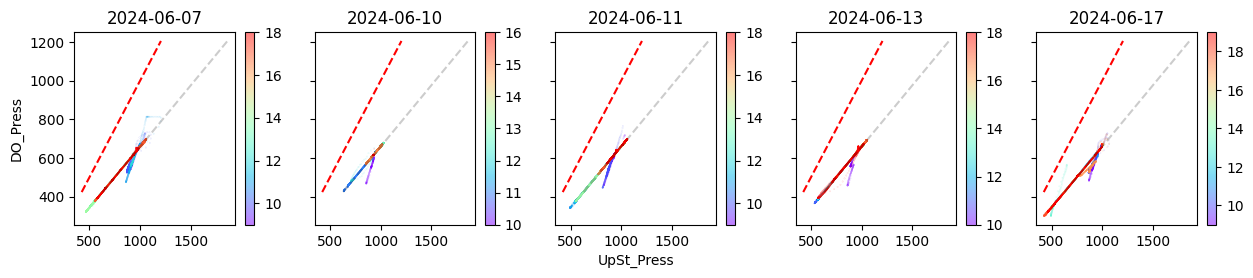

In [25]:
d_sems = d[d['dt']>pd.to_datetime('2024-6-7')]
len(d_sems['dt'].dt.date.unique())
d_sems_na = d_sems[['UpSt_Press', 'DO_Press']].dropna()
m,b = np.polyfit(d_sems_na['DO_Press'], d_sems_na['UpSt_Press'], 1)
fig, axes = plt.subplots(1,5, figsize=(15,2.5), sharex='all', sharey='all')
dates = d_sems['dt'].dt.date.unique()
acc=0
axes[0].set_ylabel('DO_Press')
axes[2].set_xlabel('UpSt_Press')
for date in dates:
    axes[acc].set_title(date)
    d_sems_sub = d_sems[d_sems['dt'].dt.date==date]
    fit = [m*d_sems['UpSt_Press'].min()+b, m*d_sems['UpSt_Press'].max()+b]
    one_to_one = [d_sems['UpSt_Press'].min(), d_sems['UpSt_Press'].max()]
    axes[acc].plot(fit, one_to_one, c='black', ls='--', alpha=.2)
    axes[acc].plot(one_to_one, one_to_one, c='red', ls='--')


    cbar = axes[acc].scatter(d_sems_sub['UpSt_Press'], d_sems_sub['DO_Press'], s=.01, c=d_sems_sub['dt'].dt.hour, cmap='rainbow', alpha=.5)
    
    
    
    acc+=1
    fig.colorbar(cbar)
fig.savefig('./figures/DOvSEMS_P.png', dpi=300, bbox_inches='tight')

In [34]:
d2 = retrieve_flows(d)

In [35]:
d2.to_csv('./tables/DASH_flow.csv', index=False)

In [30]:
d2['P_hPa'].describe()

count    250816.000000
mean        798.995855
std         211.378424
min         421.595340
25%         569.747767
50%         852.000000
75%        1009.476777
max        1089.857349
Name: P_hPa, dtype: float64

In [37]:
d2['T_C'].describe()

count    250816.000000
mean         24.397088
std           1.862416
min          19.000000
25%          23.200000
50%          24.200000
75%          25.200000
max          29.800000
Name: T_C, dtype: float64